In [312]:
import warnings
warnings.filterwarnings('ignore')

In [313]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm

In [314]:
# !pip install --upgrade "statsmodels>=0.14"

In [315]:
plt.style.use('ggplot')

In [480]:
cpih = pd.read_csv('CPIHOSNS.csv')
cpih.head()

,observation_date,CPIHOSNS
0,1967-01-01,30.5
1,1967-02-01,30.5
2,1967-03-01,30.5
3,1967-04-01,30.6
4,1967-05-01,30.7


In [482]:
cpih['CPIHOSNS'] = cpih['CPIHOSNS'].astype(float)

In [484]:
cpih['CPIHOSNS_delta'] = cpih['CPIHOSNS'].diff()

In [488]:
cpih['CPIHOSNS_log'] = np.log(cpih['CPIHOSNS'])
cpih['CPIHOSNS_logdelta'] = cpih['CPIHOSNS_log'].diff()

In [490]:
cpih.head()

,observation_date,CPIHOSNS,CPIHOSNS_delta,CPIHOSNS_log,CPIHOSNS_logdelta
0,1967-01-01,30.5,NaN,3.417727,NaN
1,1967-02-01,30.5,0.0,3.417727,0.000000
2,1967-03-01,30.5,0.0,3.417727,0.000000
3,1967-04-01,30.6,0.1,3.421000,0.003273
4,1967-05-01,30.7,0.1,3.424263,0.003263


In [564]:
cpih

,observation_date,CPIHOSNS,CPIHOSNS_delta,CPIHOSNS_log,CPIHOSNS_logdelta
0,1967-01-01,30.500,NaN,3.417727,NaN
1,1967-02-01,30.500,0.000,3.417727,0.000000
2,1967-03-01,30.500,0.000,3.417727,0.000000
3,1967-04-01,30.600,0.100,3.421000,0.003273
4,1967-05-01,30.700,0.100,3.424263,0.003263
...,...,...,...,...,...
699,2025-04-01,344.801,1.289,5.842967,0.003745
700,2025-05-01,345.938,1.137,5.846260,0.003292
701,2025-06-01,347.593,1.655,5.851032,0.004773
702,2025-07-01,348.210,0.617,5.852806,0.001773


In [492]:
cpih['observation_date'] = pd.to_datetime(cpih['observation_date'])

In [676]:
cpih_rec = cpih[cpih['observation_date'] >= pd.to_datetime('2020-01-01')]
cpih_realrec = cpih[cpih['observation_date'] >= pd.to_datetime('2024-01-01')]

Text(0, 0.5, 'CPI for Urban Consumers - Housing')

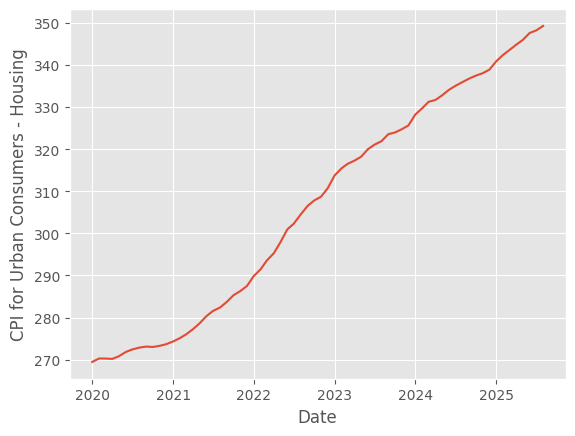

In [496]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS'])
plt.xlabel('Date')
plt.ylabel('CPI for Urban Consumers - Housing')

Text(0, 0.5, 'Monthly Change in CPIHOSNS')

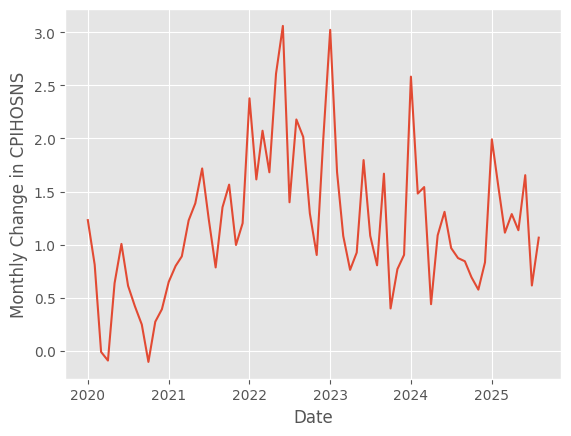

In [497]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS_delta'])
plt.xlabel('Date')
plt.ylabel('Monthly Change in CPIHOSNS')

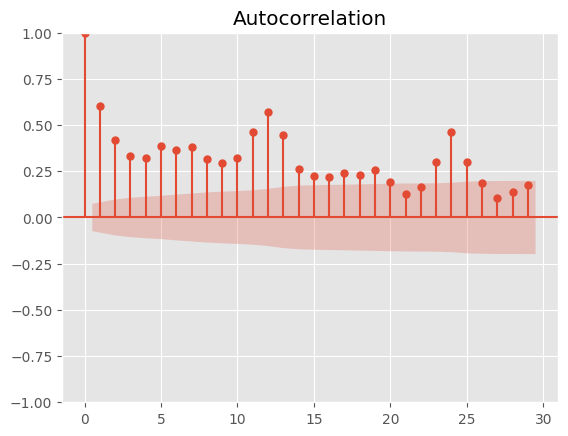

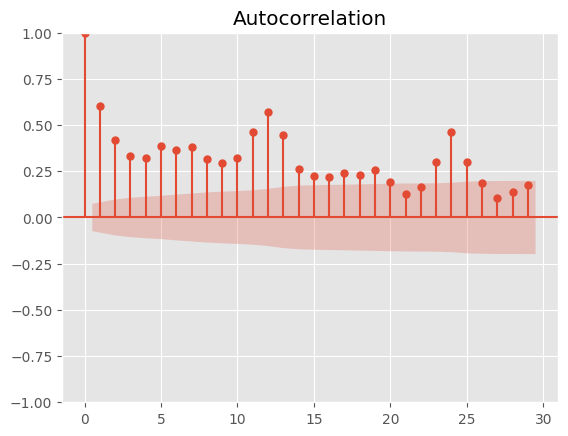

In [504]:
plot_acf(cpih['CPIHOSNS_logdelta'][1:])

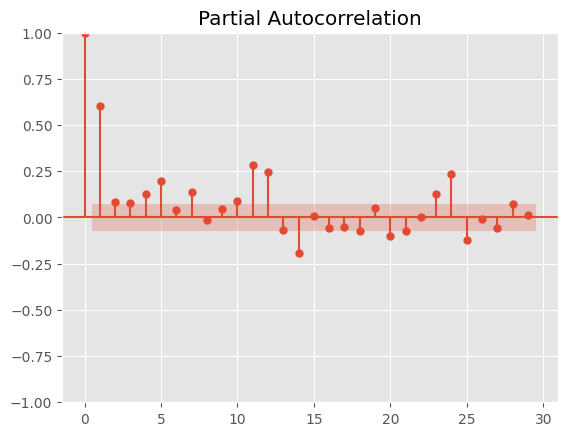

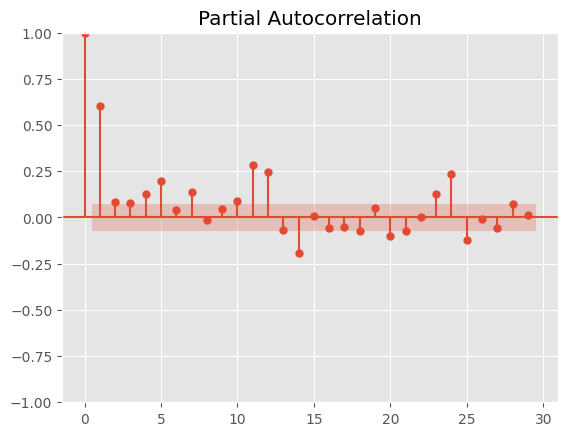

In [506]:
plot_pacf(cpih['CPIHOSNS_logdelta'][1:])

In [734]:
b = 15

In [736]:
end = cpih['CPIHOSNS_logdelta'][1:].values.shape[0] - b
end

688

In [742]:
armod_sm = AutoReg(cpih['CPIHOSNS_logdelta'][1:end].values, lags = 5).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  687
Model:                     AutoReg(5)   Log Likelihood                3047.193
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 14 Sep 2025   AIC                          -6080.386
Time:                        17:24:59   BIC                          -6048.710
Sample:                             5   HQIC                         -6068.126
                                  687                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.763      0.000       0.000       0.001
y.L1           0.5117      0.037     13.646      0.000       0.438       0.585
y.L2           0.0369      0.042      0.872      0.3

In [744]:
k, n_train = b + 1, cpih['CPIHOSNS_logdelta'][1:end].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00235455, 0.00374357, 0.00380553, 0.0038741 , 0.0032498 ,
       0.0031605 , 0.00337428, 0.00349371, 0.00356761, 0.00348204,
       0.003426  , 0.00343925, 0.0034692 , 0.00349875, 0.00349683,
       0.00348577])

In [746]:
diffs_with_pred = np.append(cpih['CPIHOSNS_logdelta'][1:end].values, fcast_mean)
diffs_with_pred.shape

(703,)

In [748]:
pred_df = pd.DataFrame({'observation_date': cpih['observation_date'][1:], 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2025-04-01,0.003439
2025-05-01,0.003469
2025-06-01,0.003499


In [750]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [752]:
pred_df['diffs'][-10:]

observation_date
2024-11-01    0.003374
2024-12-01    0.003494
2025-01-01    0.003568
2025-02-01    0.003482
2025-03-01    0.003426
2025-04-01    0.003439
2025-05-01    0.003469
2025-06-01    0.003499
2025-07-01    0.003497
2025-08-01    0.003486
Name: diffs, dtype: float64

In [754]:
cpih[-10:]

,observation_date,CPIHOSNS,CPIHOSNS_delta,CPIHOSNS_log,CPIHOSNS_logdelta
694,2024-11-01,338.048,0.578,5.823188,0.001711
695,2024-12-01,338.883,0.835,5.825655,0.002467
696,2025-01-01,340.875,1.992,5.831516,0.005861
697,2025-02-01,342.398,1.523,5.835974,0.004458
698,2025-03-01,343.512,1.114,5.839222,0.003248
699,2025-04-01,344.801,1.289,5.842967,0.003745
700,2025-05-01,345.938,1.137,5.846260,0.003292
701,2025-06-01,347.593,1.655,5.851032,0.004773
702,2025-07-01,348.210,0.617,5.852806,0.001773
703,2025-08-01,349.277,1.067,5.855865,0.003060


In [756]:
pred_df = pred_df.reset_index()

In [758]:
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])

In [760]:
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [762]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
698,2025-04-01,0.003439,5.845166,345.559795,1.186424
699,2025-05-01,0.003469,5.848635,346.760693,1.200898
700,2025-06-01,0.003499,5.852134,347.976047,1.215354
701,2025-07-01,0.003497,5.855630,349.194990,1.218943


In [768]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

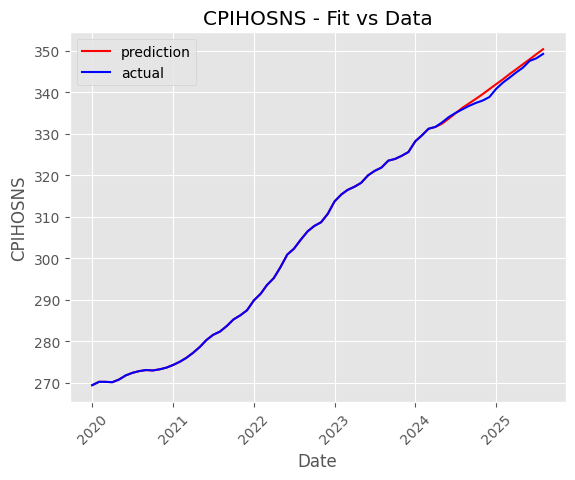

In [770]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSNS')
plt.title('CPIHOSNS - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

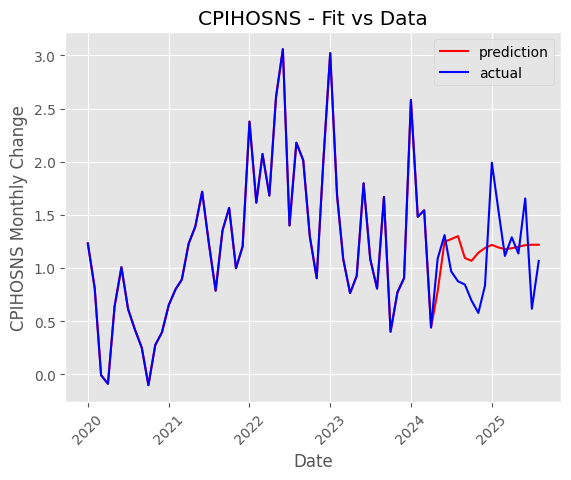

In [772]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS_delta'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSNS Monthly Change')
plt.title('CPIHOSNS - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

In [774]:
armod_sm = AutoReg(cpih['CPIHOSNS_logdelta'][1:].values, lags = 5).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  703
Model:                     AutoReg(5)   Log Likelihood                3125.260
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 14 Sep 2025   AIC                          -6236.521
Time:                        17:26:13   BIC                          -6204.683
Sample:                             5   HQIC                         -6224.212
                                  703                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.839      0.000       0.000       0.001
y.L1           0.5106      0.037     13.782      0.000       0.438       0.583
y.L2           0.0372      0.042      0.890      0.3

In [830]:
# Predictions for future
b = 20
k, n_train = b, cpih['CPIHOSNS_logdelta'][1:].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00325921, 0.00333947, 0.00363935, 0.00321228, 0.00326735,
       0.00332116, 0.00337132, 0.00345258, 0.00341091, 0.00340461,
       0.0034115 , 0.00342613, 0.00344955, 0.00345357, 0.00345534,
       0.00345802, 0.00346277, 0.00347007, 0.00347482, 0.00347791])

In [831]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [832]:
diffs_with_pred = np.append(cpih['CPIHOSNS_logdelta'][1:].values, fcast_mean)
diffs_with_pred.shape

(723,)

In [833]:
pred_df = pd.DataFrame({'observation_date': np.append(cpih['observation_date'][1:].values, dates_fut), 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2026-12-01,0.003458
2027-01-01,0.003463
2027-02-01,0.003470


In [834]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [835]:
pred_df = pred_df.reset_index()
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [836]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
718,2026-12-01,0.003458,5.910198,368.779029,1.273044
719,2027-01-01,0.003463,5.913660,370.058240,1.279211
720,2027-02-01,0.003470,5.917130,371.344599,1.286360
721,2027-03-01,0.003475,5.920605,372.637198,1.292598


In [837]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

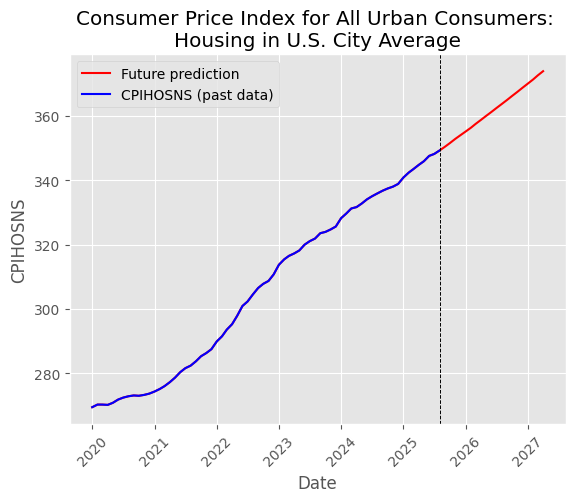

In [838]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS'], label='CPIHOSNS (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSNS')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average')
plt.xticks(rotation=45)
plt.legend();

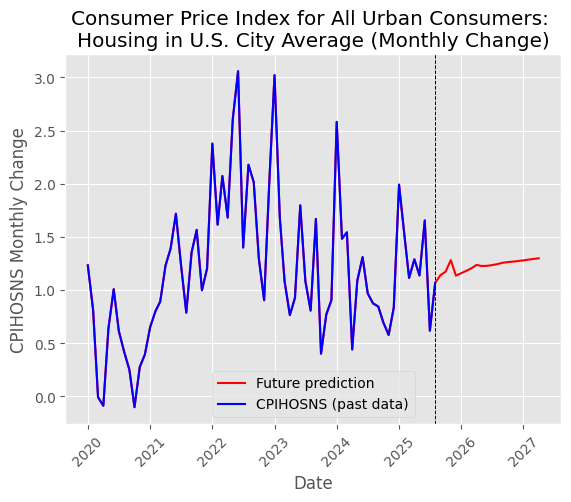

In [839]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSNS_delta'], label='CPIHOSNS (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSNS Monthly Change')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average (Monthly Change)')
plt.xticks(rotation=45)
plt.legend();